In [1]:
from fourier_radiator import __path__ as src_path


In [2]:
src_path[0] + "/kernels/"

'/Users/caijie/Library/Mobile Documents/com~apple~CloudDocs/学术文档/研究工作/SimCode/fourier_radiator/src/fourier_radiator/kernels/'

In [3]:
from fourier_radiator import FourierRadiator

calc = FourierRadiator()

In [4]:
import hickle as hkl
import numpy as np
from tqdm.notebook import tqdm

# 加载数据
tracks = hkl.load('./tracks.hkl')

# 指定目标数据类型
target_dtype = np.float32  # 或 np.float64，根据需要选择

# 如果 tracks 是一个列表或元组的形式，我们可以直接转换其中的每个元素
for i, track in tqdm(enumerate(tracks), desc="Converting tracks to float32"):
    # 假设每个 track 是一个元组，包含多个数组
    tracks[i] = tuple(np.array(item, dtype=target_dtype) for item in track)

# 现在，tracks 中的所有数据都已经转换为 target_dtype

Converting tracks to float32: 0it [00:00, ?it/s]

In [5]:
from tqdm.notebook import tqdm
from synchrad.utils import r_e, omega_1m, alpha_fs
from scipy.constants import e, m_e, c, epsilon_0, hbar

Np = 1000       # Number of electrons
Num_osc = 4     # Number of oscillations
K0 = 20.0        # Undulator strength
particle_energy_MeV = 500
n_p = 8e18 * 1e6

gamma_0 = particle_energy_MeV * 1e6 * e / (m_e * c**2)
omega_p = c * ( 4 * np.pi * r_e * n_p)**0.5 
pz0 = (gamma_0**2 - 1)**.5
gamma_0m = (1 + pz0**2 + K0**2)**.5
omega_ch = omega_p / (2 * gamma_0m)**0.5
omega_ch_crit = 3/2 * K0 * gamma_0**2 * omega_ch

omega_ch = omega_p / (2 * gamma_0m)**0.5
lambda_ch = 2 * np.pi * c / omega_ch

# Simulation length and steps
L_ch =  Num_osc * lambda_ch
T_fin  = L_ch / c
Nt = L_ch / lambda_ch * 64

t_eval = np.r_[0: T_fin: 1j * Nt]
dt = t_eval[1] - t_eval[0]

In [ ]:
calc_input = {
    "grid": [
        # (1e-3*omega_ch_crit/omega_1m, omega_ch_crit/omega_1m),  
        (1e-3*omega_ch_crit, omega_ch_crit),  
        (0, 2*K0/gamma_0),
        (0.0, 2 * np.pi),
        (512, 32, 32),
    ],  
}

omega_min, omega_max = calc_input["grid"][0]
theta_min, theta_max  = calc_input["grid"][1]
phi_min, phi_max = calc_input["grid"][2]
gridNodeNums = calc_input["grid"][3]
No, Nt, Np = gridNodeNums
# omega = np.r_[omega_min:omega_max:No*1j]
# theta = np.r_[theta_min:theta_max:Nt*1j]
omega = np.linspace(omega_min, omega_max, No, dtype=np.float32)
theta = np.linspace(theta_min, theta_max, Nt, dtype=np.float32)
phi = phi_min + (phi_max-phi_min)/Np*np.arange(Np, dtype=np.float32)

d_theta = (theta_max - theta_min) / (Nt - 1)
d_phi = (phi_max - phi_min) / (Np - 1)
d_omega = np.abs( omega[1:]-omega[:-1] )
d_V = d_theta * d_phi * d_omega

sinTheta = np.sin(theta)
cosTheta = np.cos(theta)
sinPhi = np.sin(phi)
cosPhi = np.cos(phi)

nSnaps = 1
ptnSteps = len(t_eval)
itSnaps = np.array([ptnSteps - 1], dtype=np.uint32)

In [ ]:
# Assuming `calc` is an instance of the `FourierRadiator` class
# Define the parameters
nSteps = len(t_eval)  # Set the total number of steps, assuming `t_eval` is defined

# Call compute_radiation with kwargs
spectrum = calc.compute_radiation(
    tracks=tracks,          # Particle track data
    omega=omega,            # Angular frequency
    theta=theta,            # Theta angles
    phi=phi,                # Phi angles
    dt=dt,                  # Time step
    nSteps=nSteps,          # Total steps
    itSnaps=itSnaps,        # Snapshot time steps
    nSnaps=nSnaps           # Number of snapshots
)


Calculating spectrum: 100%|██████████| 1000/1000 [00:11<00:00, 86.62it/s]


In [ ]:
import matplotlib.pyplot as plt

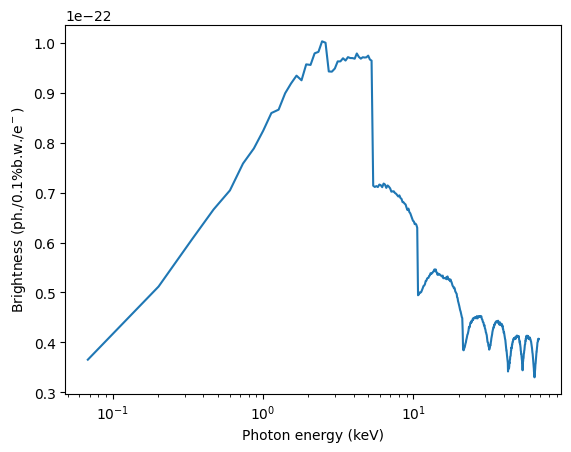

In [ ]:
from scipy.constants import alpha as alpha_fs

def get_spectrum(omega, theta, phi, val):
    d_phi = phi[1] - phi[0]
    theta_loc = 0.5 * (theta[1:] + theta[:-1])
    val_loc = 0.5 * (val[:,1:,:] + val[:,:-1,:])
    int_theta = np.trapz( val_loc * np.sin(theta_loc)[None,:,None],
                                    theta_loc, axis=1)
    val = d_phi * int_theta.sum(-1)
    return val

val = spectrum[-1]

spectrum_1d = get_spectrum(omega, theta, phi, val)
E_eV = hbar * omega / e          # 单位：eV
E_keV = E_eV / 1e3
plt.figure()
plt.plot(E_keV, spectrum_1d)
plt.xscale('log')
plt.xlabel("Photon energy (keV)")
plt.ylabel("Brightness (ph./0.1%b.w./e$^-$)")
plt.savefig("energy_spectrum_1D.png")

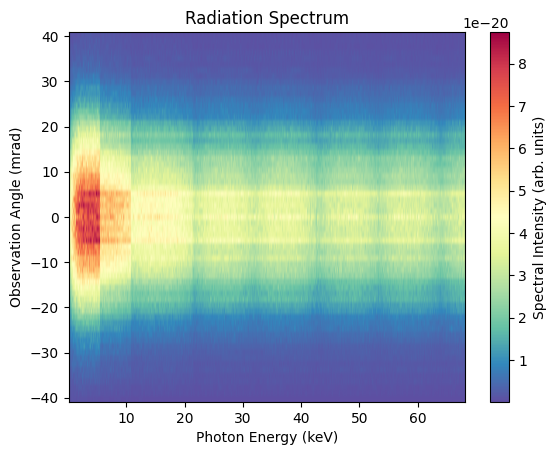

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import alpha as alpha_fs

def plot_spectrum_image(omega, theta, phi, val):
    """
    绘制二维谱图图像。

    参数:
    - spectrum: numpy 数组, 包含频谱数据，最后一个元素应为目标谱线数据。
    - calc: 一个对象，包含 `Args` 字典，包括 'theta', 'phi', 和 'omega'。
    - omega_ch_crit: 临界频率（用于归一化谱轴），默认为 None（跳过归一化轴）。
    - cmap: matplotlib colormap，用于图像色图绘制。

    返回:
    - None (直接显示图像)
    """
    
    omega_1m = 2 * np.pi * c # m/s

    # # 处理谱数据
    # spect_val = spectrum[-1].astype(np.double)
    # spect_val = alpha_fs / (4 * np.pi**2) * spect_val
    spect_val = val

    # 拼接上下半部分角度数据（对称轴合并）
    spect_val = np.c_[
        spect_val[:, :, spect_val.shape[2] // 2 - 1][:, ::-1],  # 左半部分反转
        spect_val[:, 1:, 0]                                     # 右半部分
    ]

    # 坐标轴计算
    spect_ax_keV = omega * hbar/e * 1e-3  # λ = 1.24 / E(eV) -> E(eV) = h·ω / e
    
    extent = [
        spect_ax_keV.min(), 
        spect_ax_keV.max(), 
        -theta.max() * 1e3, 
         theta.max() * 1e3
    ]
    return extent, spect_val

extent, spect_val = plot_spectrum_image(omega, theta, phi, val)

# 绘图
plt.figure()
plt.imshow(
    spect_val.T,
    extent=extent,
    cmap=plt.cm.Spectral_r,
    origin='lower',
    aspect='auto'
)
plt.xlabel("Photon Energy (keV)")
plt.ylabel("Observation Angle (mrad)")
plt.title("Radiation Spectrum")
plt.colorbar(label='Spectral Intensity (arb. units)')
plt.show()


In [ ]:
import numpy as np
from scipy.interpolate import griddata

def get_spot_cartesian_raw(omega, theta, phi, val, **kwargs):
    """
    从原始 spectrum[-1] 提取 theta-phi 分布，生成 2D 空间图。
    """
    th_part = kwargs.get('th_part', 1.0)  # theta 部分的比例
    k0 = kwargs.get('k0', None)  # 频率 k0，默认为 None
    bins = kwargs.get('bins', (100, 100))  # 网格分辨率
    
    # val = spectrum[-1].astype(np.double)  # shape: (omega, theta, phi)
    # val = norm_val(val)  # 归一化
    # 对 omega 维度积分或选取单频
    if k0 is None:
        val = np.trapz(val, omega, axis=0)  # shape: (theta, phi)
    else:
        idx = (omega < k0).sum()
        if idx + 1 < len(omega) and abs(omega[idx + 1] - k0) < abs(omega[idx] - k0):
            idx += 1
        val = val[idx]  # shape: (theta, phi)

    # 构建角度坐标
    ph_grid, th_grid = np.meshgrid(phi, theta)

    if val.shape != ph_grid.shape:
        val = val.reshape(ph_grid.shape)

    x = (th_grid * np.cos(ph_grid)).flatten()
    y = (th_grid * np.sin(ph_grid)).flatten()
    coord = (x, y)

    th_max = th_part * theta.max()
    grid_x, grid_y = np.mgrid[-th_max:th_max:bins[0]*1j, -th_max:th_max:bins[1]*1j]

    val_img = griddata(coord, val.flatten(), (grid_x, grid_y), method='linear', fill_value=0.)

    extent = [-th_max, th_max, -th_max, th_max]
    return val_img, extent

In [ ]:
val_img, extent = get_spot_cartesian_raw(omega, theta, phi, val)

plt.figure()
plt.imshow(val_img.T, extent=extent, origin='lower', aspect='auto', cmap='afmhot_r')
plt.xlabel("X (rad)")
plt.ylabel("Y (rad)")
plt.title("Beam Spot from Raw Spectrum")
plt.colorbar(label="Intensity (arb. units)")
# plt.show()
plt.xlabel("x-plane angle (mrad)")
plt.ylabel("y-plane angle (mrad)")